In [240]:
import numpy as np
import shapely
import bisect
import shapely.wkt
import matplotlib.pyplot as plt
import math
import geopandas as gpd


In [241]:
#Geometries
geom1 = shapely.wkt.loads('POLYGON ((1.1 1.2, 1.4 5.1, 5.1 5.3, 3 2, 1.1 1.2))')
geom2 = shapely.wkt.loads('POLYGON ((0 0, 2 3, 2 4, 2 4, 2.1 2.5, 4 2, 2.1 2.1, 0 0))')
geom3 = shapely.wkt.loads('POLYGON ((-24.3 10.48, -19.32 12.44, -15.3 14.2, -15.3 13.78, -15.3 13.9, -15.06 10.4, -17.44 11.38, -19.18 11.46, -14.82 9.08, -12.9 10.14, -12.08 7.86, -14.36 5.94, -15.92 8.34, -16.86 3.48, -19.38 4.4, -18.2 6.52, -20.08 7.4, -24.34 6.68, -24.24 8.66, -27.52 11.1,  -27.0 11.1, -24.3 10.48))')
geom4 = shapely.wkt.loads('POLYGON ((-9.9 16.85, -5.95 17.67, -6.19 13.49, -9.81 12.74, -7.35 9.2, -6.82 6.19, -10 6, -12.36 5.75, -14.59 8.1, -12 10, -13.93 12.31, -17.35 12.45, -16.83 15.6, -20.45 14.6, -22.36 12, -22 9.37, -27.1 6.48, -30 11.7, -27.9 15.5, -21.46 17.26, -19.6 16.1, -14.77 17.6, -11.43 13.32, -9.9 16.85))')


In [242]:
#Helpers

def get_bounds_intersect(bound_min1, bound_min2, bound_max1, bound_max2):
    if bound_min1 <= bound_min2 and bound_max1 <= bound_max2 and bound_max1 >= bound_min2:
        return (bound_min2, bound_max1)
    elif bound_min1 >= bound_min2 and bound_max1 <= bound_max2:
        return (bound_min1, bound_max1)
    if bound_min2 <= bound_min1 and bound_max2 <= bound_max1 and bound_max2 >= bound_min1:
        return (bound_min1, bound_max2)
    elif bound_min2 >= bound_min1 and bound_max2 <= bound_max1:
        return (bound_min2, bound_max2)
    else:
        return (None, None)


def binary_search_min_bound(sorted_indicies, point_list, bound_right):
    hi, lo = len(sorted_indicies) - 1, 0
    if point_list[sorted_indicies[hi]] < bound_right:
        return None
    while lo < hi:
        mid = (lo+hi)//2
        if bound_right <= point_list[sorted_indicies[mid]]: hi = mid
        else: lo = mid+1
        
    return lo

def binary_search_max_bound(sorted_indicies, point_list, bound_left):
    hi, lo = len(sorted_indicies) - 1, 0
    if point_list[sorted_indicies[lo]] > bound_left:
        return None
    while lo < hi:
        mid = math.ceil((lo+hi)/2)
        if point_list[sorted_indicies[mid]] > bound_left: hi = mid - 1
        else: lo = mid
    return lo

def divide_xs_ys(geom):
    xs, ys = [], []
    coords = shapely.get_coordinates(geom)[:-1]
    for coord in coords:
        xs.append(coord[0])
        ys.append(coord[1])
    return coords, xs, ys

def get_min_max_bounds(argsorted_xs, argsorted_ys, xs, ys, bounds):
    xs_min_idx = binary_search_min_bound(argsorted_xs, xs, bounds[0])
    xs_max_idx = binary_search_max_bound(argsorted_xs, xs, bounds[1])

    ys_min_idx = binary_search_min_bound(argsorted_ys, ys, bounds[2])
    ys_max_idx = binary_search_max_bound(argsorted_ys, ys, bounds[3])
    return xs_min_idx, xs_max_idx, ys_min_idx, ys_max_idx



In [243]:
SHOW_COORDINATES = False
SHOW_GEOMETRIES = True
SHOW_INTERSECTIONS = True
SHOW_BOUNDING_INTERSECTION = True
SHOW_BOUNDING_BOXES = True

{<LINESTRING (1.1 1.2, 1.4 5.1)>, <LINESTRING (5.1 5.3, 3 2)>}
POINT (1.1391304347826088 1.7086956521739132)
POINT (3.0324074074074074 2.050925925925926)
POINT (3.1434426229508197 2.2254098360655736)


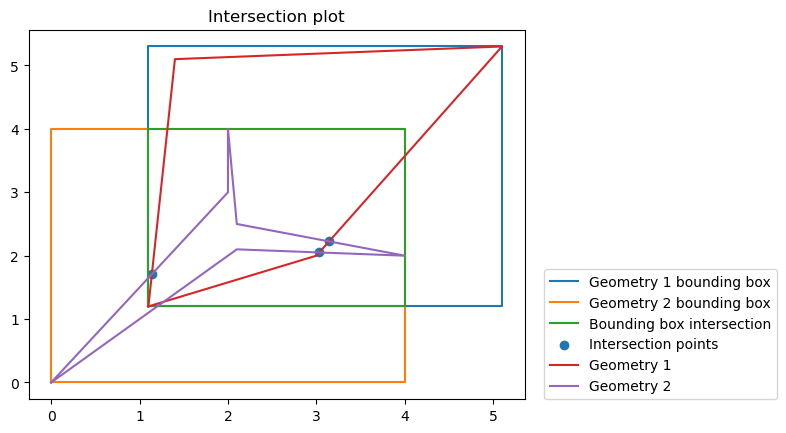

In [269]:


coords1, xs1, ys1 = divide_xs_ys(geom1)
geom1_bounds = geom1.bounds

coords2, xs2, ys2 = divide_xs_ys(geom2)
geom2_bounds = geom2.bounds

argsorted_xs1, argsorted_ys1 = np.argsort(xs1), np.argsort(ys1)
argsorted_xs2, argsorted_ys2 = np.argsort(xs2), np.argsort(ys2)

bound_xmin, bound_xmax = get_bounds_intersect(geom1_bounds[0], geom2_bounds[0], geom1_bounds[2], geom2_bounds[2])
bound_ymin, bound_ymax = get_bounds_intersect(geom1_bounds[1], geom2_bounds[1], geom1_bounds[3], geom2_bounds[3])
bounds = (bound_xmin, bound_xmax, bound_ymin, bound_ymax)

if bound_xmin == None or bound_ymin == None:
    print("Geometries cant intersect since bounding boxes are non intersecting")

else:
    xs1_min_idx, xs1_max_idx, ys1_min_idx, ys1_max_idx = get_min_max_bounds(argsorted_xs1, argsorted_ys1, xs1, ys1, bounds)
    xs2_min_idx, xs2_max_idx, ys2_min_idx, ys2_max_idx = get_min_max_bounds(argsorted_xs2, argsorted_ys2, xs2, ys2, bounds)


    in_bounds_coords1 = set(argsorted_xs1[xs1_min_idx:xs1_max_idx + 1]).intersection(set(argsorted_ys1[ys1_min_idx:ys1_max_idx + 1]))
    in_bounds_coords2 = set(argsorted_xs2[xs2_min_idx:xs2_max_idx + 1]).intersection(set(argsorted_ys2[ys2_min_idx:ys2_max_idx + 1]))

    coords1_linestrings = set()
    coords2_linestrings = set()

    for i in in_bounds_coords1:
        if i == 0:
            coords1_linestrings.add(shapely.LineString([coords1[0], coords1[1]]))
        elif i == len(coords1) - 1:
            coords1_linestrings.add(shapely.LineString([coords1[len(coords1) - 2], coords1[len(coords1) - 1]]))
        else:
            coords1_linestrings.add(shapely.LineString([coords1[i - 1], coords1[i]]))
            coords1_linestrings.add(shapely.LineString([coords1[i], coords1[i + 1]]))

    print(coords1_linestrings)                         
                                     

    for i in in_bounds_coords2:
        if i == 0:
            coords2_linestrings.add(shapely.LineString([coords2[0], coords2[1]]))
        elif i == len(coords2) - 1:
            coords2_linestrings.add(shapely.LineString([coords2[len(coords2) - 2], coords2[len(coords2) - 1]]))
        else:
            coords2_linestrings.add(shapely.LineString([coords2[i - 1], coords2[i]]))
            coords2_linestrings.add(shapely.LineString([coords2[i], coords2[i + 1]]))


    points_in_bounds_coords1 = [coords1[i] for i in in_bounds_coords1]
    points_in_bounds_coords2 = [coords2[i] for i in in_bounds_coords2]

    intersection_points_x = []
    intersection_points_y = []

    for i in coords1_linestrings:
        for j in coords2_linestrings:
            
            if i.intersects(j):
                int_point = i.intersection(j)
                print(int_point)
                intersection_points_x.append(int_point.x)
                intersection_points_y.append(int_point.y)
           

   
    legends = []
    if SHOW_BOUNDING_BOXES:
        plt.plot([geom1_bounds[0], geom1_bounds[0],geom1_bounds[2],geom1_bounds[2], geom1_bounds[0]], [geom1_bounds[1], geom1_bounds[3], geom1_bounds[3], geom1_bounds[1],geom1_bounds[1]])
        legends.append("Geometry 1 bounding box")
        plt.plot([geom2_bounds[0], geom2_bounds[0],geom2_bounds[2],geom2_bounds[2],geom2_bounds[0]], [geom2_bounds[1], geom2_bounds[3], geom2_bounds[3], geom2_bounds[1],geom2_bounds[1]])
        legends.append("Geometry 2 bounding box")


    if SHOW_BOUNDING_INTERSECTION:
        plt.plot([bound_xmin, bound_xmin,bound_xmax,bound_xmax,bound_xmin], [bound_ymin, bound_ymax,bound_ymax, bound_ymin,bound_ymin])
        legends.append("Bounding box intersection")

    if SHOW_COORDINATES:
        x_coords_geom1 = [point[0] for point in points_in_bounds_coords1]
        y_coords_geom1 = [point[1] for point in points_in_bounds_coords1]

        x_coords_geom2 = [point[0] for point in points_in_bounds_coords2]
        y_coords_geom2 = [point[1] for point in points_in_bounds_coords2]
    
        plt.scatter(x_coords_geom1, y_coords_geom1)
        legends.append("Geometry 1 coordinates")
        plt.scatter(x_coords_geom2, y_coords_geom2)
        legends.append("Geometry 2 coordinates")
    
    if SHOW_INTERSECTIONS:
        plt.scatter(intersection_points_x, intersection_points_y)
        legends.append("Intersection points")

    if SHOW_GEOMETRIES:
        x1, y1 = geom1.exterior.xy
        x2, y2 = geom2.exterior.xy
        plt.plot(x1, y1)
        legends.append("Geometry 1")
        plt.plot(x2, y2)
        legends.append("Geometry 2")

    plt.legend(legends, bbox_to_anchor=(1.04, 0), loc="lower left", borderaxespad=0)
    plt.title("Intersection plot")
    plt.tight_layout
    plt.show()

